<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Angewandte Geophysik II: Kap 9: Filterung
## Synthetischer Brockenpluton
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

In diesem Notebook simulieren wir die Schwere- und Magnetfeldanomalie, die durch eine große
Magmenkammer im Untergrund (*Brockenpluton*) hervorgerufen wird.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def change_fontsize(SMALL_SIZE=15,MEDIUM_SIZE=20,BIGGER_SIZE=25):
    """
    re-set matplotlib fonts with three different sizes:
    SMALL_SIZE=15 (default)
    MEDIUM_SIZE=20 (default)
    BIGGER_SIZE=25 (default)
    """
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
change_fontsize()

Wir nutzen die Funktionen, die wir für die Vorhersage des Schwerefeldes und de Magnetfeldes
der Kugel geschrieben haben ...

In [3]:
def grav_sphere(xo,yo,zo,xp,yp,zp,radius,rho):
    """
    !-----------------------------------------------------------------------
    ! Bouguer-Anomaly for a buried sphere
    ! x-axis is north, z-axis vertically down
    !
    ! Input parameters:
    ! xo,yo,zo [m]       - location of observation point
    ! xp,yp,zp [m]       - location of center of sphere
    ! rho [kg/m^3]       - density difference
    ! radius [m]         - radius of sphere
    !
    ! Output parameter:
    ! gx,gy,gz [mGal]    - gravity component at observation point
    !
    ! from:
    ! Blakeley (1995): Potential theory in gravity & magnetic applications
    !-----------------------------------------------------------------------
    """
    G       = 6.672e-11     # m^3/kg/s^2
    si2mgal = 1.e5          # m/s^2 -> mGal

    rx   = xo - xp
    ry   = yo - yp
    rz   = zo - zp
    r    = rx**2 + ry**2 + rz**2
    if (r == 0):
        print ('grav_sphere: obs. point in centrum of sphere')
    r    = np.sqrt(r)
    r3   = r**3
    mass = 4./3.*np.pi*rho*radius**3
    gx = -G * mass * rx/ r3 * si2mgal
    gy = -G * mass * ry/ r3 * si2mgal
    gz = -G * mass * rz/ r3 * si2mgal
    return gx,gy,gz

In [4]:
def dircos(incl,decl,azim):
    """
    !-----------------------------------------------------------------------
    ! Input parameters:
    ! incl [degrees]     - inclination positive below horizontal
    ! decl [degrees]     - declination positive east from north
    ! azim [degrees]     - azimuth of x axis in degrees positive east to north
    ! Output parameter:
    ! a,b,c              - three direction cosines
    !
    ! from: 
    ! Blakeley (1995): Potential theory in gravity & magnetic applications
    !-----------------------------------------------------------------------
    """
    deg2rad = np.pi / 180.

    a = np.cos(incl*deg2rad) * np.cos((decl-azim)*deg2rad)
    b = np.cos(incl*deg2rad) * np.sin((decl-azim)*deg2rad)
    c = np.sin(incl*deg2rad)
    return a,b,c

In [5]:
def mag_sphere (xo,yo,zo,xp,yp,zp,radius,earthincl,earthdecl,mag,incl,decl,theta):
    """
    !-----------------------------------------------------------------------
    ! Magnetic anomaly of a uniformly magnetised sphere.
    ! x-axis is north, z-axis vertically down
    !
    ! Input parameters:
    ! xo,yo,zo [m]         - location of observation point
    ! xp,yp,zp [m]         - location of center of sphere
    ! radius [m]           - radius of sphere
    ! earthincl [degrees]  - inclination of earth field, positive below horizontal
    ! earthdecl [degrees]  - declination of earth field, positive east of true north
    ! mag [A/m]            - magnetisation      
    ! incl [degrees]       - inclination of magnetisation, positive below horizontal
    ! decl [degrees]       - declination of magnetisation, positive east of true north
    ! theta [degrees]      - azimuth of x axis in degrees positive east to north
    !
    ! Output parameter:
    ! bx,by,bz [nT]        - Magnetic induction component at observation point
    ! t [nT]               - Total field at observation point
    !
    ! from:
    ! Blakeley (1995): Potential theory in gravity & magnetic applications
    !-----------------------------------------------------------------------
    """
    mu04pi  = 1.000e-7      # Vs/Am
    t2nt    = 1.e9          # T -> nT
    mx,my,mz = dircos (incl,decl,theta)
    fx,fy,fz = dircos (earthincl,earthdecl,theta)

    rx   = xo - xp
    ry   = yo - yp
    rz   = zo - zp
    r2   = rx**2 + ry**2 + rz**2
    if (r2 == 0):
        print ('mag_sphere: obs point in centrum of sphere')
    r    = np.sqrt(r2)
    r5   = r**5
    dot  = rx*mx + ry*my + rz*mz
    moment = 4./3.*np.pi*mag*radius**3
    bx = t2nt * mu04pi * moment * (3.*dot*rx - r2*mx) / r5
    by = t2nt * mu04pi * moment * (3.*dot*ry - r2*my) / r5
    bz = t2nt * mu04pi * moment * (3.*dot*rz - r2*mz) / r5
    t  = fx*bx + fy*by + fz*bz
    return bx,by,bz,t

----
## 3D model of plutonic body

<img src=figures/brockenpluton.jpg style=width:12cm>

Wir definieren ein Messgitter über den *Brockenpluton*, mit $x \in [-50,50]$ km
und $y \in [-50,50]$ km.

In [12]:
nx=100
ny=100
x = np.linspace(-50000, 50000, nx)
y = np.linspace(-50000, 50000, ny)
# re-mesh for 2D plot
X, Y = np.meshgrid(y,x)

In [13]:
print(X.shape)

(100, 100)


In [14]:
boug = np.zeros(nx*ny).reshape(nx,ny)
total = np.zeros(nx*ny).reshape(nx,ny)

In [15]:
print(boug.shape)

(100, 100)


Die Kugel liegt in $D=25$km Tiefe, hat einen Radius von $R=20$km, die Dichtedifferenz ist
$\Delta \rho=200$kg/m$^3$, di Magnetisierung $M=0.04$A/m, Inklination und Deklination des
alten Feldes sind $I=30^{\circ}$ und $D=45^{\circ}$.

In [20]:
for i in range(boug.shape[0]):
    for j in range(boug.shape[1]):
        gx,gy,boug[i,j] = grav_sphere(xo=X[i,j],yo=Y[i,j],zo=0,xp=0,yp=0,zp=25.e3,radius=20.e3,rho=200)
        bx,by,bz,total[i,j] = mag_sphere(xo=X[i,j],yo=Y[i,j],zo=0,xp=0,yp=0,zp=25.e3,radius=20.e3,
                        earthincl=67.,earthdecl=0.,mag=0.4,incl=30.,decl=45.,theta=0.)
        #print("%10.2f %10.2f %5.2f %5.2f" % (X[i,j],Y[i,j],boug[i,j],total[i,j]))

Text(0.5, 0, 'Total field [nT]')

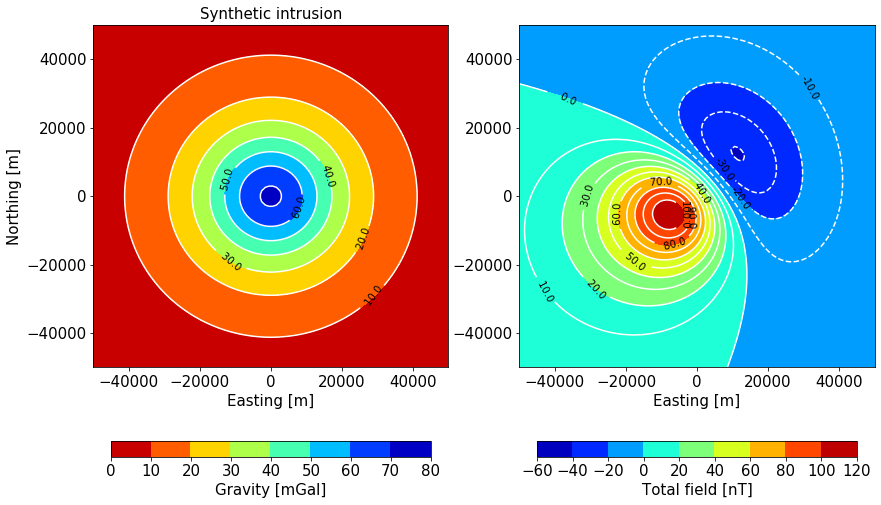

In [21]:
fig,axs = plt.subplots(1,2,figsize=(14.0,9.0))

axs[0].set_title('Synthetic intrusion')

axs[0].set_xlabel('Easting [m]')
axs[0].set_ylabel('Northing [m]')
CS1=axs[0].contourf(X, Y, boug,cmap=plt.cm.jet_r)
CS2= axs[0].contour(X, Y, boug,colors='white')
axs[0].clabel(CS2, inline=1, fontsize=10,fmt='%5.1f',colors='black')
cbar = fig.colorbar(CS1,ax=axs[0],orientation="horizontal",shrink=0.9)
cbar.ax.set_xlabel('Gravity [mGal]')

levels = np.array([i for i in np.linspace(-100,100,21)])
axs[1].set_xlabel('Easting [m]')
#axs[1].set_ylabel('Northing [m]')
CS3=axs[1].contourf(X, Y, total,cmap=plt.cm.jet)
CS4= axs[1].contour(X, Y, total,colors='white',levels=levels)
axs[1].clabel(CS4, inline=1, fontsize=10,fmt='%5.1f',colors='black')
cbar = fig.colorbar(CS3,ax=axs[1],orientation="horizontal",shrink=0.9)
cbar.ax.set_xlabel('Total field [nT]')

... done